# GSI Land Classification Primer
#### Author: Alexey Tarutin

This notebook gives an overview of the proposed GSI land classification mechanism, alongside results from a previous project in the same area of interest. The point of this is to improve upon this using notions of textural and windowed predictions based purely on optical imagery from a single date.

This notebook outlines the following:
* Reading the data
* Clipping the data to the AOI
* Preparing the data for machine learning
* Training/prediction
* Accuracy validation
* Post-processing
* Writing output

Supplemental material to this notebook:
* In the data/ directory
 * A Level 2 Sentinel-2 Scene from 28th of November 2017
 * A land classification map based on Corine from 2018 for training
 * Field boundaries for the area courtesy of the Centre for Ecology and Hydrology for aggregation of results
 * Validation boundaries created by GSI
* environment.yml to create the Anaconda environment on your local machine. If you don't use Anaconda, please install the Python 3 distribution for your system: https://docs.conda.io/en/latest/miniconda.html
 * This is populated with the following command: `conda env create -f environment.yml`
 * Activate with: `conda activate geo`

In [1]:
import rasterio as rio
import geopandas as gpd
import os
import sys
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import pylab as pl
from fiona.crs import from_epsg
from shapely.geometry import box as geobox
from rasterstats import zonal_stats

## Step 1
Create a GeoJSON file using the coordinates for the area. This is to allow us to validate and verify data fit.

In [2]:
aoi_geo = geobox(-2.29, 51.51, -1.71, 51.61)
aoi = gpd.GeoDataFrame([], geometry=[aoi_geo])
aoi.crs = from_epsg(4326)
aoi.to_file('./data/aoi.geojson', driver='GeoJSON')

We have prepared a package named `land_classification` that gives a simple structure for file IO, dataset sampling and cleaning, machine learning, output validation, and postprocessing.

You are welcome to modify functions in this as appropriate. Expect bugs.

In [3]:
import land_classification as lc

## Step 2
Load in Sentinel-2 scene data. 

Notes:
* We are only using a single scene for this exercise. We want to maximise our ability to create land classification maps on only one image, this will also help us extend this to other applications such as change detection and phenology analysis.
* This scene was downloaded from the Sentinel-2 Google Cloud Storage repository in SAFE format as Level-1C. This file was then processed to Level-2A using Sen2Cor for the advantages it provides, including atmospheric correction and improved cloud detection. Further information about level 2 Sentinel-2 imagery, advantages, and the relevant algorithms is available here: https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm

In [4]:
s2_band = 'S2A_MSIL2A_20171128T111411_N0206_R137_T30UWC_20171128T130743.SAFE'
data, profile = lc.merge_bands(s2_band)
lc.write_raster('data/merged.tif', data, profile)

Writing raster data/merged.tif with 4 bands.
Writing band 1 of 4
Writing band 2 of 4
Writing band 3 of 4
Writing band 4 of 4
File data/merged.tif written.


In [5]:
lc.mask_raster(aoi, 'data/merged.tif', 'data/masked.tif')

Writing raster data/masked.tif with 4 bands.
Writing band 1 of 4
Writing band 2 of 4
Writing band 3 of 4
Writing band 4 of 4
File data/masked.tif written.


In [16]:
bands = ['B02', 'B03', 'B04', 'B08']
pe = lc.PointExtractor(aoi)
points_df = pe.get_n(10000)

points_df = lc.sample_raster(points_df, 'data/Corine_10m_OS_AoI1.tif', bands=['labels'])
points_df = lc.sample_raster(points_df, 'data/masked.tif', bands = bands)
clean_df = lc.remove_outliers(points_df, indices=False)
clean_df = lc.create_zero_samples(clean_df)

clean_df = lc.calc_indices(clean_df)

/home/alexey/GSI/projects/msc/land_classification/land_classification/preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lab_clean['labels'] = i
/home/alexey/miniconda3/envs/geo/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/alexey/GSI/projects/msc/land_classification/land_classification/preprocessing.py:14: RuntimeWarning: invalid value encountered in less
  lab_clean = lab_df[(pl.absolute(stats.zscore(lab_df)) < 1).all(axis=1)]


In [4]:
c_tif = rio.open('data/Corine_10m_OS_AoI1.tif')

In [5]:
c_data = c_tif.read()

In [8]:
mask_src = rio.open('data/masked.tif')
profile = mask_src.profile
data = mask_src.read(list(pl.arange(mask_src.count) + 1))
gdf = create_raster_df(data)
gdf = calc_indices(gdf)

In [9]:
gdf['labels'] = lc.create_raster_df(pred_array=c_data, bands=['labels'])['labels']

In [10]:
def convert_to_numeric(feature_series):
    """
    Get numeric representation of string classes
    """
    feat_list = sorted(list(feature_series.unique()))
    return dict(zip(feat_list, pl.array(range(len(feat_list)))+1))


In [11]:
gdf['labels'][gdf['B02'] == -9999] = 0

In [12]:
clean_df = lc.remove_outliers(gdf)


/home/alexey/miniconda3/envs/geo/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/alexey/GSI/projects/msc/land_classification/land_classification/preprocessing.py:14: RuntimeWarning: invalid value encountered in less
  lab_clean = lab_df[(pl.absolute(stats.zscore(lab_df)) < 1).all(axis=1)]
/home/alexey/GSI/projects/msc/land_classification/land_classification/preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lab_clean['labels'] = i


In [13]:
clean_df = lc.create_zero_samples(clean_df)
clean_df = lc.calc_indices(clean_df)

In [7]:
from sklearn.neural_network import MLPClassifier
import rasterio as rio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pylab as pl
import seaborn as sns
import os

from land_classification import create_raster_df, create_zero_samples
from land_classification import calc_indices
from land_classification import write_raster

def classify(df, 
             pred_path='data/masked.tif', 
             cv=True, 
             name='mlp', 
             algorithm=MLPClassifier()):    
    assert isinstance(pred_path, str) or isinstance(pred_path, rio.DatasetReader)
    
    if isinstance(pred_path, str):
        mask_src = rio.open(pred_path)
    else:
        mask_src = pred_path
        
    X = df.drop(['labels'], axis=1)
    y = df[['labels']]
    
    profile = mask_src.profile
    data = mask_src.read(list(pl.arange(mask_src.count) + 1))
    gdf = create_raster_df(data)
    gdf = calc_indices(gdf)
    if cv:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    else:
        X_train, y_train = X, y
    cls = algorithm
    cls.fit(X_train, y_train['labels'].ravel())
    pred = cls.predict(gdf).reshape(1, data.shape[1], data.shape[2]).astype(pl.int16)
    proba = cls.predict_proba(gdf).max(axis=1).reshape(1, data.shape[1], data.shape[2])
    if not os.path.exists('outputs'):
        os.makedirs('outputs')
    write_raster("outputs/lc_10m_{}_pred.tif".format(name), pred, profile, nodata=0)
    write_raster("outputs/lc_10m_{}_proba.tif".format(name), proba, profile)
    
    if cv:
        cls_cv = cls.predict(X_test)
        score = cls.score(X_test, y_test)
        print(score)
        cm = confusion_matrix(cls_cv, y_test)
        vals = list(set(y_test['labels']))
        f, ax = pl.subplots(1, figsize = (20, 20))
        sns.heatmap(ax=ax,
                    data=cm,
                    annot=True,
                    fmt='g',
                    linewidths=0.5,
                    cbar=False)
        ax.set_title('{} Confusion Matrix'.format(name))
        ax.set_ylabel('Predicted')
        ax.set_xlabel('True')
        pl.xticks(pl.arange(len(vals)), vals)
        pl.yticks(pl.arange(len(vals)), vals)
        f.savefig('outputs/cv_{}.png'.format(name))
    else:
        cm = None
    return pred, proba, cm, cls

In [94]:
def filter_low_counts(df):
    return df.groupby('labels').filter(lambda x: x.shape[0] > 1000)

clean_df = filter_low_counts(gdf)

In [102]:
def balance_samples(df, samples=1000):
    return df.groupby('labels').apply(lambda x: x.sample(samples)).reset_index(drop=True)

clean_df = balance_samples(clean_df)

In [104]:
train_df = balance_samples(clean_df, samples=1000)

In [105]:
X = train_df.drop('labels', axis=1)
Y = train_df['labels']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
pred, proba, cm, cls = classify(train_df, name='cv_svm_sampled', algorithm=SVC())

/home/alexey/miniconda3/envs/geo/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [107]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy
 
# Function to create model, required for KerasClassifier
def create_model():
	# create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(len(Y.value_counts()), activation='sigmoid'))
    # Compile model

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model
 
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
#dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
#X = dataset[:,0:8]
#Y = dataset[:,8]
# create model
monitor = 'accuracy'
mode = 'max'
earlystop = EarlyStopping(monitor=monitor, mode=mode, patience=10)
reduce_lr = ReduceLROnPlateau(monitor=monitor, mode=mode, factor=0.1, patience=3, verbose=1)
callbacks = [earlystop, reduce_lr]
model = KerasClassifier(build_fn=create_model, 
                        epochs=150, 
                        batch_size=128, 
                        verbose=1)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

Epoch 1/150
23400/23400 [==============================] - 1s 37us/step - loss: 7.4552 - acc: 0.0292
Epoch 2/150
23400/23400 [==============================] - 0s 16us/step - loss: 5.3790 - acc: 0.0380
Epoch 3/150
23400/23400 [==============================] - 0s 16us/step - loss: 4.9101 - acc: 0.0380
Epoch 4/150
23400/23400 [==============================] - 0s 16us/step - loss: 3.7468 - acc: 0.0384
Epoch 5/150
23400/23400 [==============================] - 0s 16us/step - loss: 3.7394 - acc: 0.0385
Epoch 6/150
23400/23400 [==============================] - 0s 16us/step - loss: 3.7356 - acc: 0.0385
Epoch 7/150
23400/23400 [==============================] - 0s 16us/step - loss: 3.7328 - acc: 0.0385
Epoch 8/150
23400/23400 [==============================] - 0s 16us/step - loss: 3.7307 - acc: 0.0385
Epoch 9/150
23400/23400 [==============================] - 0s 17us/step - loss: 3.7290 - acc: 0.0385
Epoch 10/150
23400/23400 [==============================] - 0s 16us/step - loss: 3.7276 - a

KeyboardInterrupt: 

In [4]:
# MLP for Pima Indians Dataset with grid search via sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy
from tqdm import tqdm
 
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', init='glorot_uniform'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=8, kernel_initializer=init, activation='relu'))
	model.add(Dense(8, kernel_initializer=init, activation='relu'))
	model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model
 
# fix random seed for reproducibility
seed = 651
numpy.random.seed(seed)
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


/home/alexey/miniconda3/envs/geo/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/alexey/miniconda3/envs/geo/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Error when checking target: expected dense_3 to have shape (1,) but got array with shape (2,)

In [7]:
Y

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 0.

In [23]:
len(list(set(pred.flatten())))

20

In [94]:
with open('data/labels.json') as jf:
    labels = json.load(jf)

In [95]:
labels

{'0': 'No data',
 '1': 'Continuous urban fabric',
 '2': 'Discontinuous urban fabric',
 '3': 'Industrial or commercial units',
 '4': 'Road and rail networks and associated land',
 '5': 'Port areas',
 '6': 'Airports',
 '7': 'Mineral extraction sites',
 '8': 'Dump sites',
 '9': 'Construction sites',
 '10': 'Green urban areas',
 '11': 'Sport and leisure facilities',
 '12': 'Non-irrigated arable land',
 '13': 'Permanently irrigated land',
 '14': 'Rice fields',
 '15': 'Vineyards',
 '16': 'Fruit trees and berry plantations',
 '17': 'Olive groves',
 '18': 'Pastures',
 '19': 'Annual crops associated with permanent crops',
 '20': 'Complex cultivation patterns',
 '21': 'Land principally occupied by agriculture  with significant areas of natural vegetation',
 '22': 'Agro-forestry areas',
 '23': 'Broad-leaved forest',
 '24': 'Coniferous forest',
 '25': 'Mixed forest',
 '26': 'Natural grasslands',
 '27': 'Moors and heathland',
 '28': 'Sclerophyllous vegetation',
 '29': 'Transitional woodland-shrub',

In [98]:
df.columns = list(map(str, df.columns))

In [99]:
df

,geometry,2,12,18,25,3,6,1,23,41,10,11
0,(POLYGON ((587978.0969977799 5715786.479352801...,15.0,75.0,4.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(POLYGON ((579041.4547556334 5716372.70807113,...",10.0,70.0,49.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,(POLYGON ((579781.4154145647 5713951.777037508...,17.0,83.0,40.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,(POLYGON ((580526.8969578199 5715917.301896587...,21.0,276.0,381.0,49.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,(POLYGON ((558365.1942237659 5709313.103712394...,5.0,76.0,124.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"(POLYGON ((559282.396460313 5708190.049994076,...",5.0,67.0,10.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN
6,(POLYGON ((554771.9029434919 5714531.214724405...,12.0,106.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,(POLYGON ((554460.2206443256 5716272.158341065...,1.0,54.0,50.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
8,(POLYGON ((571383.3079097066 5707204.769759798...,22.0,95.0,1.0,36.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
9,(POLYGON ((561391.7872602581 5709010.369999346...,2.0,52.0,41.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
df.to_file('outputs/grouped.geojson', driver='GeoJSON')

In [110]:
df['pred_class'] = df.drop(columns='geometry').idxmax(axis=1)

In [111]:
df

,geometry,2,12,18,25,3,6,1,23,41,10,11,pred_class
0,(POLYGON ((587978.0969977799 5715786.479352801...,15.0,75.0,4.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
1,"(POLYGON ((579041.4547556334 5716372.70807113,...",10.0,70.0,49.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,12
2,(POLYGON ((579781.4154145647 5713951.777037508...,17.0,83.0,40.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
3,(POLYGON ((580526.8969578199 5715917.301896587...,21.0,276.0,381.0,49.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,18
4,(POLYGON ((558365.1942237659 5709313.103712394...,5.0,76.0,124.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
5,"(POLYGON ((559282.396460313 5708190.049994076,...",5.0,67.0,10.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,12
6,(POLYGON ((554771.9029434919 5714531.214724405...,12.0,106.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
7,(POLYGON ((554460.2206443256 5716272.158341065...,1.0,54.0,50.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,12
8,(POLYGON ((571383.3079097066 5707204.769759798...,22.0,95.0,1.0,36.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,12
9,(POLYGON ((561391.7872602581 5709010.369999346...,2.0,52.0,41.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


In [104]:
df.idxmax()

TypeError: reduction operation 'argmax' not allowed for this dtype

In [78]:
pd.pivot_table(df,
               index=df.index)

,1,2,3,6,10,11,12,18,23,25,41
0,NaN,15.0,NaN,NaN,NaN,NaN,75.0,4.0,NaN,61.0,NaN
1,NaN,10.0,1.0,1.0,NaN,NaN,70.0,49.0,NaN,4.0,NaN
2,NaN,17.0,NaN,NaN,NaN,NaN,83.0,40.0,NaN,7.0,NaN
3,NaN,21.0,NaN,1.0,NaN,NaN,276.0,381.0,NaN,49.0,NaN
4,NaN,5.0,NaN,NaN,NaN,NaN,76.0,124.0,NaN,3.0,NaN
5,NaN,5.0,1.0,2.0,NaN,NaN,67.0,10.0,NaN,1.0,NaN
6,NaN,12.0,NaN,NaN,NaN,NaN,106.0,9.0,NaN,6.0,NaN
7,NaN,1.0,1.0,1.0,NaN,NaN,54.0,50.0,NaN,4.0,NaN
8,1.0,22.0,NaN,NaN,NaN,NaN,95.0,1.0,NaN,36.0,NaN
9,NaN,2.0,NaN,NaN,NaN,NaN,52.0,41.0,NaN,13.0,NaN


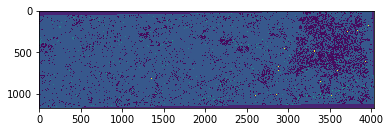

In [50]:
pl.imshow(tif.read(1))

# Window based clustering

Below is a naive implementation of aggregating neibouring pixels by a window. This is more of a illustrative attempt and is very much subject to improvement. These include
* Using a variable stride for the sliding window. Right now it's a constant based on the window size
* Random sampling of image
* Allow prediction on class patches

In [103]:
win_res = 10 ## Window resolution of 10 implies 100m pixels to predict
data_30 = pl.zeros(shape=(data.shape[0], int(data.shape[1]/win_res), int(data.shape[1]/win_res), win_res, win_res))

feature_stack = pl.zeros(shape=(pl.array(data_30.shape[1:3]).prod(), data_30.shape[0]*pl.array(data_30.shape[3:]).prod()))
k = 0
for i in pl.arange(data_30.shape[1]):
    for j in pl.arange(data_30.shape[2]):
        tmp_ar = data[:, (i*win_res):(i*win_res)+win_res, (j*win_res):(j*win_res)+win_res]
        row = pl.zeros((win_res ** 2) * data.shape[0])
        for l, a in enumerate(tmp_ar):
            af = a.flatten()
            pl.shuffle(af)
            row[(l*(win_res**2)):(l*(win_res**2)) + (win_res**2)] = af
        feature_stack[k, :] = row
        k += 1
feature_stack = pl.stack(feature_stack)